# Polynomial Regression

In [1]:
import arviz as az
import bambi as bmb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from typing import Optional


plt.style.use("arviz-darkgrid")
SEED = 1234
np.random.seed(SEED)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


This example will discuss polynomial regression using Bambi. Unlike many other examples shown, there aren't specific polynomial methods or families implemented in Bambi, most of the interesting behavior for polynomial regression occurs within the formula definition. Regardless, there are some nuances that are useful to be aware of. 

This example uses the kinematic equations from classical mechanics as a backdrop. Specifically, an object in motion experiencing constant acceleration can be described by the following:

$$x_f = \frac{1}{2} a t^2 + v_0 t + x_0$$

Where $x_0$ and $x_f$ are the initial and final locations, $v_0$ is the initial velocity, and $a$ is acceleration.

## A falling ball

First, we'll consider a simple falling ball, released from 50 meters. In this situation, $v_0 = 0$ $m$/$s$, $x_0 = 50$ $m$ and $a = g$, the acceleration due to gravity, $-9.81$ $m$/$s^2$. So dropping out the $v_0 t$ component, the equation takes the form:

$$x_f = \frac{1}{2} g t^2 + x_0$$

We'll start by simulating data for the first 2 seconds of motion. We will also assume some measurement error with a gaussian distribution of $\sigma = 0.3$.

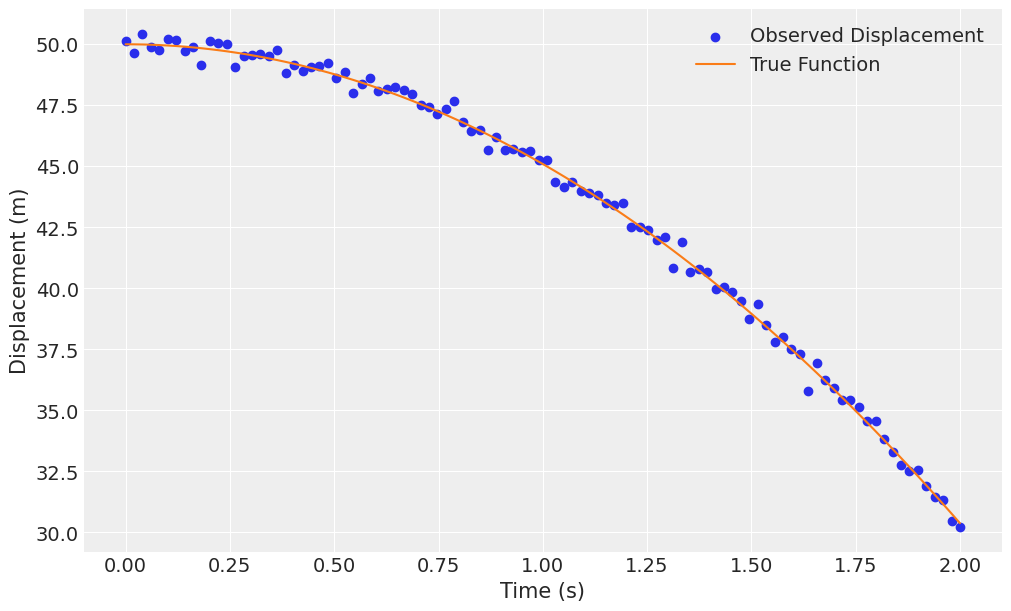

In [2]:
g = -9.81  # acceleration due to gravity (m/s^2)
t = np.linspace(0, 2, 100)  # time in seconds
inital_height = 50
x_falling = 0.5 * g * t**2 + inital_height
noise = np.random.normal(0, 0.3, x_falling.shape)
x_obs_falling = x_falling + noise
df_falling = pd.DataFrame({'t': t, 'x': x_obs_falling})

plt.figure(figsize=(10, 6))
plt.scatter(t, x_obs_falling, label='Observed Displacement', color="C0")
plt.plot(t, x_falling, label='True Function', color="C1")
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.legend()
plt.show()

Casting the equation $x_f = \frac{1}{2} g t^2 + x_0$ into a regression context, we let time be the independent variable, and displacement the dependent. This allows our coefficients to be proportional to $g$ and $x_0$. The intercept, $\beta_0$ corresponds exactly to $x_0$. Letting $\beta_1 = \frac{1}{2} g$ then gives $g = 2\beta_1$ when $x_1 = t^2$, meaning we're doing _polynomial regression_. We can put this into Bambi via the following, optionally including the `+ 1` to emphasize that we choose to include the coefficient. 

In [3]:
model_falling = bmb.Model("x ~ I(t**2) + 1", df_falling)
results_falling = model_falling.fit(idata_kwargs={"log_likelihood": True}, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_sigma, Intercept, I(t ** 2)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


The term `I(t**2)` indicates to evaluate inside the `I`. For including _just the $t^2$ term_, you can express it any of the following ways:  

- `I(t**2)`
- `{t**2}`
- Square the data directly, and pass as a new column

To verify, we'll fit the other two versions as well.

In [4]:
model_falling_variation1 = bmb.Model(
    "x ~ {t**2} + 1",  # Employing {t**2} syntax
    df_falling
)
results_variation1 = model_falling_variation1.fit(random_seed=SEED)

model_falling_variation2 = bmb.Model(
    "x ~ tsquared + 1",  # Using data with the t variable squared
    df_falling.assign(tsquared=t**2)  # Creating the tsquared variable for use in the formula
)
results_variation2 = model_falling_variation2.fit(random_seed=SEED)

print("I{t**2} coefficient: ", round(results_falling.posterior["I(t ** 2)"].values.mean(), 4))
print("{t**2} coefficient: ", round(results_variation1.posterior["I(t ** 2)"].values.mean(), 4))
print("tsquared coefficient: ", round(results_variation2.posterior["tsquared"].values.mean(), 4))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_sigma, Intercept, I(t ** 2)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_sigma, Intercept, tsquared]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


I{t**2} coefficient:  -4.9123
{t**2} coefficient:  -4.9123
tsquared coefficient:  -4.9123


Each of these provides identical results, giving -4.9, which is $g/2$. This yields exactly the $-9.81$ $m$/$s^2$ acceleration that generated the data. Looking at our model summary,

In [5]:
az.summary(results_falling)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,50.020,0.045,49.931,50.101,0.001,0.0,6578.0,3266.0,1.0
I(t ** 2),-4.912,0.025,-4.958,-4.863,0.000,0.0,6465.0,2938.0,1.0
x_sigma,0.305,0.022,0.264,0.348,0.000,0.0,5970.0,3054.0,1.0


We see that both $g/2 = -4.9$ (so $g=-9.81$) and the original height of $x_0 = 50$ $m$ are recovered, along with the injected noise.

We can then use the model to answer some questions, for example would the ball land? This would correspond to $x_f = 0$.

$$0 = \frac{1}{2} g t^2 - x_0$$

$$t = \sqrt{2x_0 / g}$$

In [6]:
calculated_x0 = results_falling.posterior["Intercept"].values.mean()
calculated_g = -2 * results_falling.posterior["I(t ** 2)"].values.mean()
calculated_land = np.sqrt(2 * calculated_x0 / calculated_g)
print(f"The ball will land at {round(calculated_land, 2)} seconds")

The ball will land at 3.19 seconds


Or if we want to account for our measurement error and use the full posterior,

In [7]:
calculated_x0_posterior = results_falling.posterior["Intercept"].values
calculated_g_posterior = -2 * results_falling.posterior["I(t ** 2)"].values
calculated_land_posterior = np.sqrt(2 * calculated_x0_posterior / calculated_g_posterior)
lower_est = round(np.quantile(calculated_land_posterior, 0.025), 2)  
upper_est = round(np.quantile(calculated_land_posterior, 0.975), 2)
print(f"The ball landing will be measured between {lower_est} and {upper_est} seconds")

The ball landing will be measured between 3.18 and 3.21 seconds


## Projectile Motion

Next, instead of a ball strictly falling, instead imagine one thrown straight upward. In this case, we add the initial velocity back into the equation.

$$x_f = \frac{1}{2} g t^2 + v_0 t + x_0$$

We will envision the ball tossed upward, starting at 1.5 meters above ground level. It will be tossed at 7 m/s upward. It will also stop when hitting the ground.


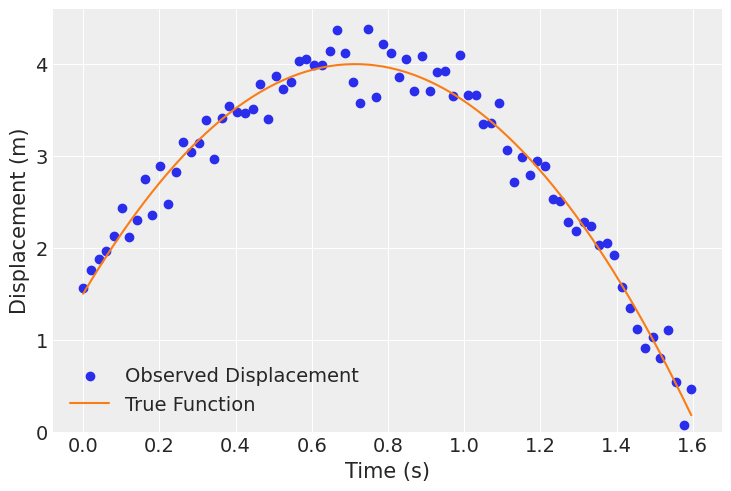

In [8]:
v0 = 7
x0 = 1.5
x_projectile = (1/2) * g * t**2 + v0 * t + x0
noise = np.random.normal(0, 0.2, x_projectile.shape)
x_obs_projectile = x_projectile + noise
df_projectile = pd.DataFrame({"t": t, "x": x_obs_projectile, "x_true": x_projectile})
df_projectile = df_projectile[df_projectile["x"] >= 0]

plt.scatter(df_projectile.t, df_projectile.x, label='Observed Displacement', color="C0")
plt.plot(df_projectile.t, df_projectile.x_true, label='True Function', color="C1")
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.ylim(bottom=0)
plt.legend()
plt.show()

Modeling this using Bambi, we must include the linear term on time to capture the inital velocity. We'll do the following regression,

$$x_f = \beta_0 + \beta_1 t + \beta_2 t^2$$

Which then maps the solved coefficents to the following: $\beta_0 = x_0$, $\beta_1 = v_0$, and $\beta_2 = \frac{g}{2}$. First, explicitly writing out each term gives the following.

In [9]:
model_projectile_all_terms = bmb.Model("x ~ I(t**2) + t + 1", df_projectile)
fit_projectile_all_terms = model_projectile_all_terms.fit(idata_kwargs={"log_likelihood": True}, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_sigma, Intercept, I(t ** 2), t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [10]:
az.summary(fit_projectile_all_terms)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.518,0.066,1.389,1.638,0.001,0.001,2586.0,2647.0,1.0
I(t ** 2),-4.892,0.115,-5.096,-4.662,0.002,0.002,2219.0,2223.0,1.0
t,6.976,0.189,6.621,7.332,0.004,0.003,2271.0,2204.0,1.0
x_sigma,0.200,0.017,0.170,0.232,0.000,0.000,2152.0,1657.0,1.0


In [11]:
hdi = az.hdi(fit_projectile_all_terms.posterior, hdi_prob=0.95)
print(f"Initial height: {hdi['Intercept'].sel(hdi='lower'):.2f} to {hdi['Intercept'].sel(hdi='higher'):.2f} meters (True: {x0} m)")
print(f"Initial velocity: {hdi['t'].sel(hdi='lower'):.2f} to {hdi['t'].sel(hdi='higher'):.2f} meters per second (True: {v0} m/s)")
print(f"Acceleration: {2*hdi['I(t ** 2)'].sel(hdi='lower'):.2f} to {2*hdi['I(t ** 2)'].sel(hdi='higher'):.2f} meters per second squared (True: {g} m/s^2)")

Initial height: 1.38 to 1.64 meters (True: 1.5 m)
Initial velocity: 6.60 to 7.35 meters per second (True: 7 m/s)
Acceleration: -10.22 to -9.32 meters per second squared (True: -9.81 m/s^2)


We once again are able to recover all our input parameters.

Aside from explicitly putting in each term, if you want to include _all_ terms of a variable up to a given degree, we can also use the keyword `poly`. In our case, if we want the linear and quadratic effects, we would designate `poly(t, 2)`.

In [12]:
model_projectile_poly = bmb.Model("x ~ poly(t, 2) + 1", df_projectile)
fit_projectile_poly = model_projectile_poly.fit(idata_kwargs={"log_likelihood": True}, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_sigma, Intercept, poly(t, 2)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [13]:
az.summary(fit_projectile_poly)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.905,0.022,2.863,2.946,0.000,0.000,6759.0,3730.0,1.0
"poly(t, 2)[0]",-3.458,0.195,-3.813,-3.068,0.003,0.002,5705.0,3303.0,1.0
"poly(t, 2)[1]",-8.531,0.198,-8.906,-8.159,0.003,0.002,5534.0,2838.0,1.0
x_sigma,0.200,0.016,0.171,0.231,0.000,0.000,5661.0,3068.0,1.0


Wait, those aren't the generated parameters! What's going on here?

## The `poly` keyword

To fully understand what's going on under the hood, we must take a bit of a linear algebra detour. When the `poly` keyword is used, instead of directly using the values of $x, x^2, x^2, \dots x^n$, it converts to _orthogonal polynomials_. When including the effect from polynomial terms, there will be correlation between them. This can be a problem from the fitting perspective as a result of multicollinarity. By orthogonalizing, the correlation is removed by design.

As it turns out, it's shockingly difficult to get any information on _how_ the orthogonalization is performed online. So instead, I went into the [source code for the R Stats library](https://svn.r-project.org/R/trunk/src/library/stats/R/contr.poly.R) where poly is defined and found explicit code. 

Here's a step-by-step summary, along with a toy example.

- The data is first centered around the mean for stability

In [14]:
X = np.array([1, 2, 3, 4, 5])

mean = np.mean(X)
X_centered = X - mean
print(f"Array: {X}, mean: {mean}.\nCentered: {X_centered}")

Array: [1 2 3 4 5], mean: 3.0.
Centered: [-2. -1.  0.  1.  2.]


- A _Vandermonde matrix_ is created. This just takes the input data and generates a matrix where columns represent increasing polynomial degrees. In this example, the first column is $x^0$, a constant term. The second is $x^1$, or the centered data. The third column is $x^2$ and the fourth is $x^3$.

In [15]:
poly_term = 3  # Which final polynomial term we want, x^3
degree = poly_term + 1  # How many terms we want, accounting for constant 
simple_vander = np.vander(X_centered, N=degree+1, increasing=True)
simple_vander

array([[ 1., -2.,  4., -8., 16.],
       [ 1., -1.,  1., -1.,  1.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8., 16.]])

- QR decomposition is performed. There are [several methods to doing this in practice](https://en.wikipedia.org/wiki/QR_decomposition), the most common being the [Gram-Schmidt process](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process). Here I just take advantage of the [Numpy implementation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html). We take the above matrix and convert it into two components, an orthogonal matrix $Q$, and an upper triangular matrix $R$.

In [16]:
q, r = np.linalg.qr(simple_vander)
print("Orthogonal matrix Q:\n", q.round(4))
print("\nUpper triangular matrix R:\n", r.round(4))

Orthogonal matrix Q:
 [[-0.4472 -0.6325  0.5345 -0.3162 -0.1195]
 [-0.4472 -0.3162 -0.2673  0.6325  0.4781]
 [-0.4472 -0.     -0.5345  0.     -0.7171]
 [-0.4472  0.3162 -0.2673 -0.6325  0.4781]
 [-0.4472  0.6325  0.5345  0.3162 -0.1195]]

Upper triangular matrix R:
 [[ -2.2361  -0.      -4.4721  -0.     -15.2053]
 [  0.       3.1623   0.      10.7517   0.    ]
 [  0.       0.       3.7417   0.      16.5702]
 [  0.       0.       0.       3.7947   0.    ]
 [  0.       0.       0.       0.      -2.8685]]


- Last take the dot product of $Q$ with the diagonal elements of $R$. $Q$ is then scaled to the magnitude of the polynomial degrees in $R$. This serves as our transformation matrix which transforms input data into the space defined by the orthogonal polynomials.


In [17]:
diagonal = np.diag(np.diag(r))
transformation_matrix = np.dot(q, diagonal)
print(transformation_matrix.round(4))


[[ 1.     -2.      2.     -1.2     0.3429]
 [ 1.     -1.     -1.      2.4    -1.3714]
 [ 1.     -0.     -2.      0.      2.0571]
 [ 1.      1.     -1.     -2.4    -1.3714]
 [ 1.      2.      2.      1.2     0.3429]]


- From the transformation matrix, we get squared norms (`norm2`), which give us the scale of each polynomial. We also get the value by which we need to shift each polynomial to match the centered data (`alpha`).


In [18]:
norm2 = np.sum(transformation_matrix**2, axis=0)

weighted_sums = np.sum(
    (transformation_matrix**2) * np.reshape(X_centered, (-1, 1)),
    axis=0
)        
normalized_sums = weighted_sums / norm2
adjusted_sums = normalized_sums + mean
alpha = adjusted_sums[:degree]

print(f"Norm2: {norm2}\nalpha: {alpha}")

Norm2: [ 5.         10.         14.         14.4         8.22857143]
alpha: [3. 3. 3. 3.]


- Finally, we iteratively apply this to all desired polynomial degrees, shifting the data and scaling by the squared norms appropriately to maintain orthogonality with the prior term.

In [19]:
transformed_X = np.full((len(X), degree+1), np.nan)
transformed_X[:,0] = 1
transformed_X[:, 1] = X - alpha[0]
for i in range(1, degree):
    transformed_X[:, i + 1] = (
        (X - alpha[i]) * transformed_X[:, i] -
        (norm2[i] / norm2[i - 1]) * transformed_X[:, i - 1]
    )

transformed_X /= np.sqrt(norm2)
transformed_X  

array([[ 0.4472136 , -0.63245553,  0.53452248, -0.31622777,  0.11952286],
       [ 0.4472136 , -0.31622777, -0.26726124,  0.63245553, -0.47809144],
       [ 0.4472136 ,  0.        , -0.53452248, -0.        ,  0.71713717],
       [ 0.4472136 ,  0.31622777, -0.26726124, -0.63245553, -0.47809144],
       [ 0.4472136 ,  0.63245553,  0.53452248,  0.31622777,  0.11952286]])

This is now a matrix of orthogonalized polynomials of X. The first column is just a constant. The second column corresponds to the input $x$, the next is $x^2$ and so on.


This approach been reproduced below as a Scikit-Learn style class below where the `fit` method calculates the coefficients and the `transform` method returns orthoginalized data. This does not use the `BaseEstimator` or `TransformerMixin` inheritances typically used in Scikit-Learn definitions (as to not increase dependencies for the sake of this one example). An implementation including those can be found [at this gist](https://gist.github.com/tjburch/062547b3600f81db73b40feb044bab2a#file-orthogonalpolynomialtransformer-py).

In [20]:
class OrthogonalPolynomialTransformer:
    """Transforms input data using orthogonal polynomials."""
    
    def __init__(self, degree: int = 1) -> None:
        self.degree = degree + 1  # Account for constant term
        self.norm2 = None
        self.alpha = None

    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> 'OrthogonalPolynomialTransformer':
        """Calculate transformation matrix, extract norm2 and alpha.""" 
        # Reset state-related attributes at the beginning of each fit call
        self.norm2 = None
        self.alpha = None

        X = np.asarray(X).flatten()
        if self.degree >= len(np.unique(X)):
            raise ValueError("'degree' must be less than the number of unique data points.")
        
        # Center data around its mean
        mean = np.mean(X)
        X_centered = X - mean
        
        # Create Vandermonde matrix for centered data and perform QR decomposition
        vandermonde = np.vander(X_centered, N=self.degree + 1, increasing=True)
        Q, R = np.linalg.qr(vandermonde)
        
        # Compute transformation matrix and norms
        diagonal = np.diag(np.diag(R))  # extract diagonal, then create diagonal matrix
        transformation_matrix = np.dot(Q, diagonal)
        self.norm2 = np.sum(transformation_matrix**2, axis=0)
        
        # Get alpha
        # Normalized weighted sum sqared of transformation matrix
        weighted_sums = np.sum(
            (transformation_matrix**2) * np.reshape(X_centered, (-1, 1)),
            axis=0
        )        
        normalized_sums = weighted_sums / self.norm2
        adjusted_sums = normalized_sums + mean
        self.alpha = adjusted_sums[:self.degree]
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """Iteratively apply up to 'degree'."""
        X = np.asarray(X).flatten()
        transformed_X = np.empty((len(X), self.degree + 1))  # Adjusted to include all polynomial degrees
        
        transformed_X[:, 0] = 1  # x^0 
        if self.degree > 0:
            transformed_X[:, 1] = X - self.alpha[0]

        if self.degree > 1:
            for i in range(1, self.degree):
                transformed_X[:, i + 1] = (
                    (X - self.alpha[i]) * transformed_X[:, i] -
                    (self.norm2[i] / self.norm2[i - 1]) * transformed_X[:, i - 1]
                )

        transformed_X /= np.sqrt(self.norm2)
        
        # return without constant term
        return transformed_X[:, 1:self.degree]  


    def fit_transform(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> np.ndarray:
        self.fit(X, y)
        return self.transform(X)


An example call is shown below. It's worth noting that in this implementation, the constant term is not returned, the first column corresponds to $x$, the second to $x^2$, and the third to $x^3$.

In [21]:

X = np.array([1, 2, 3, 4, 5])
poly3 = OrthogonalPolynomialTransformer(degree=3).fit(X)
poly3.transform(X)

array([[-0.63245553,  0.53452248, -0.31622777],
       [-0.31622777, -0.26726124,  0.63245553],
       [ 0.        , -0.53452248, -0.        ],
       [ 0.31622777, -0.26726124, -0.63245553],
       [ 0.63245553,  0.53452248,  0.31622777]])

This matches what you may get when calling the same function in R:

```{R}
X <- c(1, 2, 3, 4, 5)
poly(X, 3)
                 1          2             3
[1,] -6.324555e-01  0.5345225 -3.162278e-01
[2,] -3.162278e-01 -0.2672612  6.324555e-01
[3,] -3.288380e-17 -0.5345225  9.637305e-17
[4,]  3.162278e-01 -0.2672612 -6.324555e-01
[5,]  6.324555e-01  0.5345225  3.162278e-01
```

For an example, applying this function to x over a domain from 0-10,

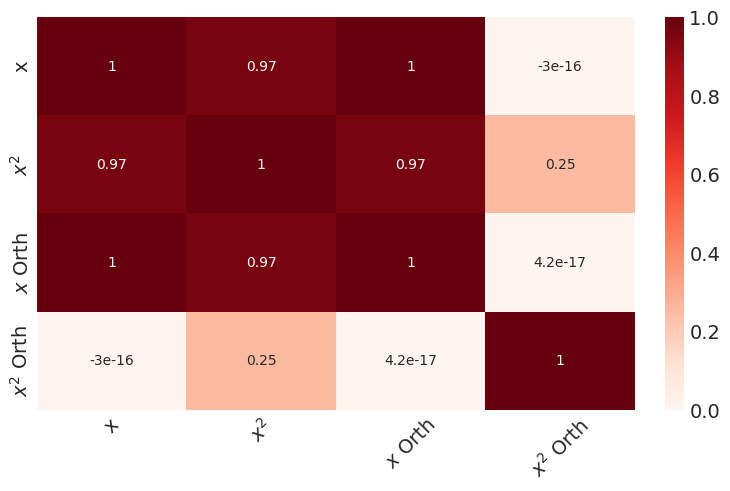

In [22]:
# Generate data
x = np.linspace(0, 10, 100)
x2 = x**2

# Orthogonalize
transformer = OrthogonalPolynomialTransformer(degree=2)
x_orthogonalized = transformer.fit_transform(x)
x_orth = x_orthogonalized[:, 0]
x2_orth = x_orthogonalized[:, 1]

# Make a correlation matrix
data = np.vstack([x, x2, x_orth, x2_orth]).T
df = pd.DataFrame(data, columns=['x', '$x^2$', '$x$ Orth', '$x^2$ Orth'])
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Reds')
plt.xticks(rotation=45)
plt.show()


We now see that the orthogonalized version of $x$ and $x^2$ are no longer correlated to each other. Next, we construct a response variable and plot against it.

/var/folders/yp/g4z_ylx565j4hzgny6j2phtc0000gn/T/ipykernel_49397/1071596866.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


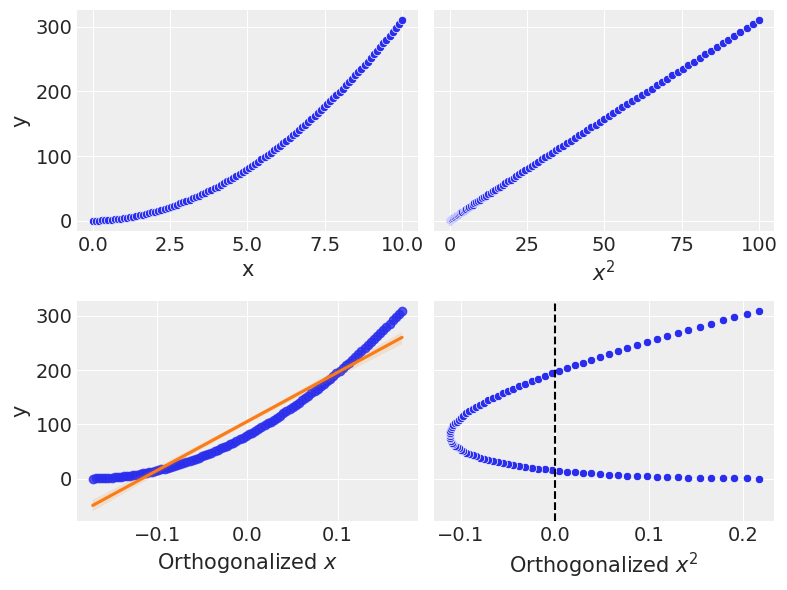

In [23]:
y = 3 * x2  + x

fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey='row')

# Plot configurations - variable, label, linear fit tuple
plots = [
    (x, 'x', False),
    (x2, '$x^2$', False),
    (x_orth, 'Orthogonalized $x$', True), 
    (x2_orth, 'Orthogonalized $x^2$', False)
]

for ax, plot_data in zip(axs.flat, plots):
    x_val, xlabel = plot_data[:2]
    if len(plot_data) == 3 and plot_data[2]:  # Check if regression line is needed
        sns.regplot(x=x_val, y=y, ax=ax, line_kws={"color": "C1"})
    else:
        sns.scatterplot(x=x_val, y=y, ax=ax)
    ax.set(xlabel=xlabel, ylabel='y')

    # Check if this is the $x^2$ Orth vs y plot to add a vertical line at 0
    if plot_data[1] == 'Orthogonalized $x^2$':
        ax.axvline(0, color='k', linestyle='--')  # Add vertical line at x=0

plt.tight_layout()
plt.show()


The top half shows the response variable against $x$ and $x^2$, this should look familiar.

The bottom half shows the new orthogonalized polynomial terms. First, you'll notice the domain is centered at 0 and more compressed than the original scale, which is done within the orthogonalization process. Otherwise, the $x$ term is the same. Remember in the construction, the first order is untouched, then subsequent terms are built orthogonal to the first degree polynomial. 

I've shown a linear fit on top of the first order term. What you'll notice is that the orthogonalized $x^2$ correspond to the residuals of this line. At the lowest values of $y$, the fit is poor, and this is where the orthogonalized $x^2$ is highest. As the first order term crosses the linear fit, you see the orthogonalized $x^2$ cross zero, then go to negative values as it dips under the linear fit. It crosses 0 one more time and then is once again poor at the highest values shown. Since the $x^2$ is proportional to the residuals of the first order term, if we plot the orthogonalized $x^2$ term against the residuals, we should see a linear trend.

/var/folders/yp/g4z_ylx565j4hzgny6j2phtc0000gn/T/ipykernel_49397/4033978437.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


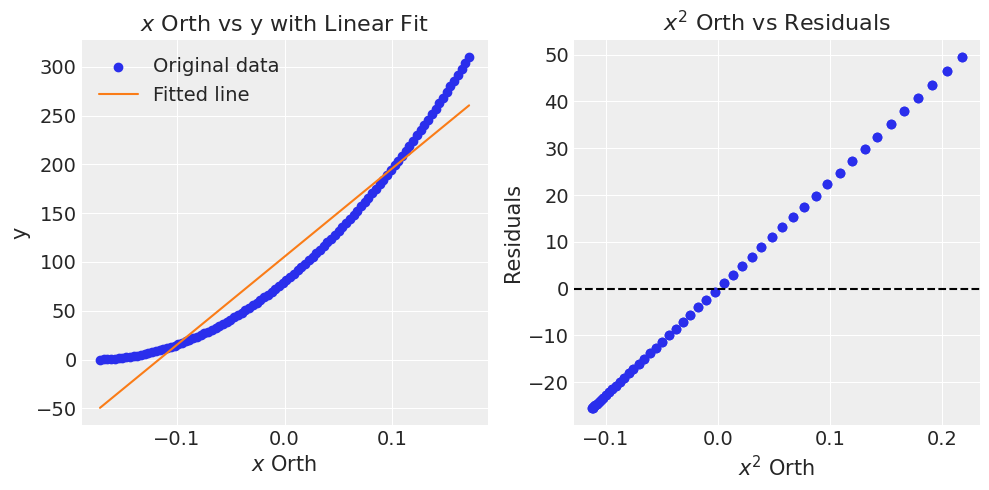

In [24]:
# Perform linear fit on x_orth vs y
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_orth, y)

# Calculate the residuals
y_pred = intercept + slope * x_orth
residuals = y - y_pred

# Plot x_orth vs y with linear fit
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_orth, y, label='Original data')
plt.plot(x_orth, y_pred, color='C1', label='Fitted line')
plt.xlabel('$x$ Orth')
plt.ylabel('y')
plt.title('$x$ Orth vs y with Linear Fit')
plt.legend()

# Plot x2_orth vs residuals
plt.subplot(1, 2, 2)
plt.scatter(x2_orth, residuals)
plt.xlabel('$x^2$ Orth')
plt.ylabel('Residuals')
plt.title('$x^2$ Orth vs Residuals')
plt.axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()


And, in fact, the linear trend bears out when plotting the orthogonal $x^2$ vs the residuals.

We can take this a degree higher and look at a cubic term.

/var/folders/yp/g4z_ylx565j4hzgny6j2phtc0000gn/T/ipykernel_49397/2104140763.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


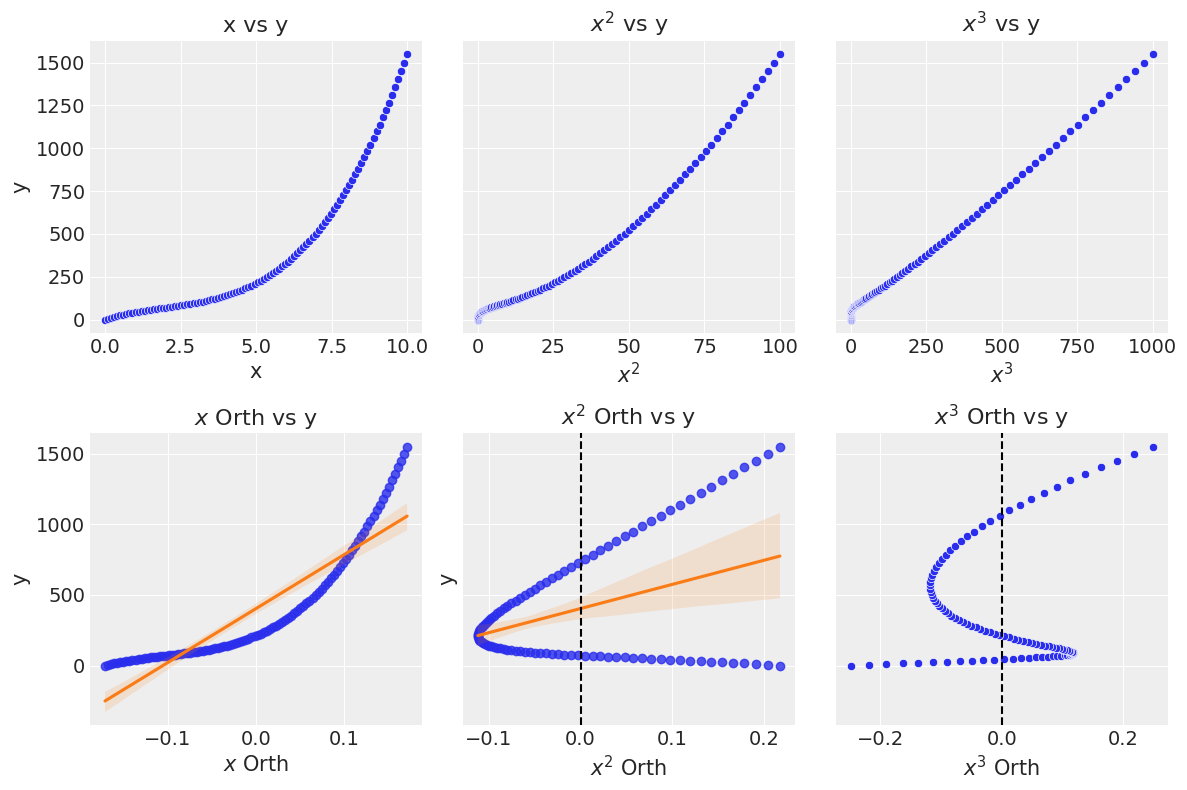

In [25]:
x3 = x**3
x2 = x**2
# Creating a cubic function with an up and down pattern
y_cubic = 2.5* x3 - 15*x2 + 55 * x 

transformer = OrthogonalPolynomialTransformer(degree=3)
x_orthogonalized = transformer.fit_transform(x)
x_orth = x_orthogonalized[:, 0]
x2_orth = x_orthogonalized[:, 1]
x3_orth = x_orthogonalized[:, 2]

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey='row')

# Plot configurations
plots = [
    (x, 'x', 'x vs y', False),
    (x2, '$x^2$', '$x^2$ vs y', False),
    (x3, '$x^3$', '$x^3$ vs y', False),
    (x_orth, '$x$ Orth', '$x$ Orth vs y', True),  # Indicate to add regression line for this plot
    (x2_orth, '$x^2$ Orth', '$x^2$ Orth vs y', True),  # Indicate to add regression line for this plot too
    (x3_orth, '$x^3$ Orth', '$x^3$ Orth vs y',False)
]

for ax, plot_data in zip(axs.flat, plots):
    x_val, xlabel, title = plot_data[:3]
    if len(plot_data) == 4 and plot_data[3]:  # Check if regression line is needed
        sns.regplot(x=x_val, y=y_cubic, ax=ax, line_kws={"color": "C1"})
    else:
        sns.scatterplot(x=x_val, y=y_cubic, ax=ax)
    ax.set(xlabel=xlabel, ylabel='y', title=title)

    # Check if this is the $x^2$ Orth vs y plot to add a vertical line at 0
    if title == '$x^2$ Orth vs y':
        ax.axvline(0, color='k', linestyle='--')  # Add vertical line at x=0
    # Check if this is the $x^3$ Orth vs y plot to add a vertical line at 0
    if title == '$x^3$ Orth vs y':
        ax.axvline(0, color='k', linestyle='--')  # Add vertical line at x=0

plt.tight_layout()
plt.show()


At a cubic level, it's a bit more difficult to see the trends, however, the procedure is still the same. We can model each subsequent term against the residuals of the prior, and we can see that since this data was constructed from a cubic function, the $x^3$ plot against the residuals of the $x^2$ term is linear.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/yp/g4z_ylx565j4hzgny6j2phtc0000gn/T/ipykernel_49397/3135338099.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


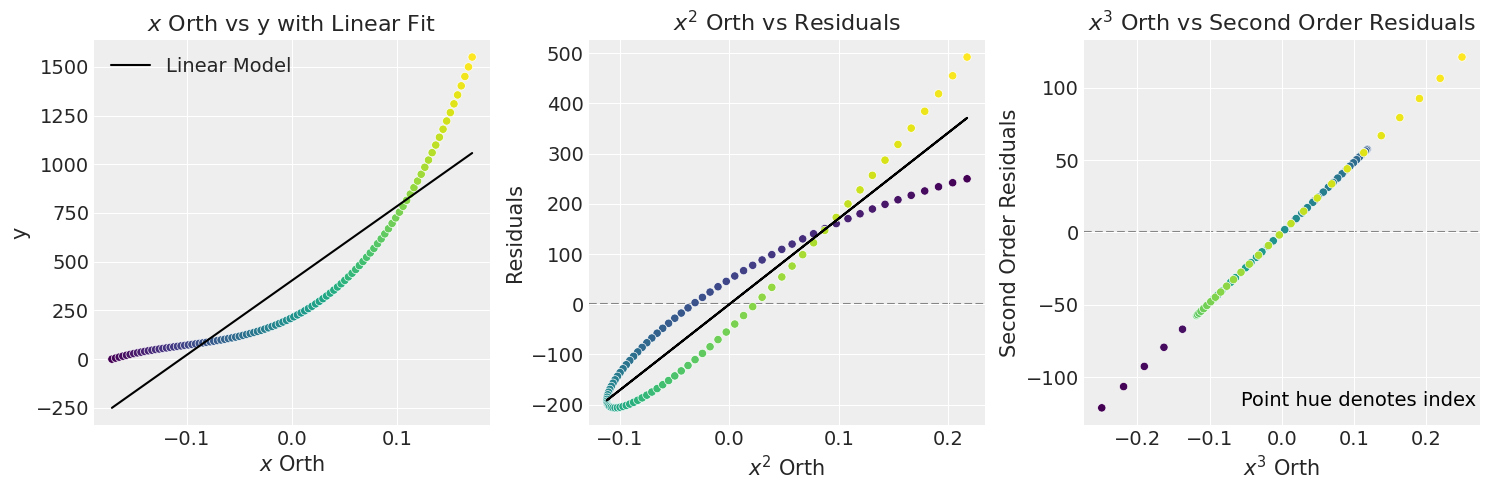

In [26]:
# Perform linear fit on x_orth vs y
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_orth, y_cubic)

# Calculate the residuals
y_pred = intercept + slope * x_orth
residuals = y_cubic - y_pred

# Perform linear fit on residuals vs x2_orth
slope_res, intercept_res, r_value_res, p_value_res, std_err_res = scipy.stats.linregress(x2_orth, residuals)

# Calculate the second order residuals
residuals_pred = intercept_res + slope_res * x2_orth
second_order_residuals = residuals - residuals_pred

# Plot x_orth vs y with linear fit
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x=x_orth, y=y_cubic, hue=np.arange(len(x_orth)), palette="viridis", legend=False)
plt.plot(x_orth, y_pred, color='black', label='Linear Model')
plt.xlabel('$x$ Orth')
plt.ylabel('y')
plt.title('$x$ Orth vs y with Linear Fit')
plt.legend()

# Plot x2_orth vs residuals
plt.subplot(1, 3, 2)
sns.scatterplot(x=x2_orth, y=residuals, hue=np.arange(len(x2_orth)), palette="viridis", legend=False)
plt.plot(x2_orth, residuals_pred, color='black')
plt.xlabel('$x^2$ Orth')
plt.ylabel('Residuals')
plt.title('$x^2$ Orth vs Residuals')
plt.axhline(0, color='grey', linestyle='--', zorder=-1)
plt.legend()

# Plot x3_orth vs second order residuals
plt.subplot(1, 3, 3)
sns.scatterplot(x=x3_orth, y=second_order_residuals, hue=np.arange(len(x3_orth)), palette="viridis", legend=False)
plt.xlabel('$x^3$ Orth')
plt.ylabel('Second Order Residuals')
plt.title('$x^3$ Orth vs Second Order Residuals')
plt.axhline(0, color='grey', linestyle='--', zorder=-1)
plt.annotate('Point hue denotes index', 
             xy=(0.99, 0.05), ha='right', xycoords='axes fraction', fontsize=14, color='black')

plt.tight_layout()
plt.show()


The main takeaway of this aside is the following: 

**The `poly` keyword when used in a formula creates orthogonal polynomials. This is well suited for fitting statistical models, since it eliminates the risk of multicollinearity between terms.** However, since we are trying to fit a physics-based model and doing parameter recovery, we will stick with the `I{x**2}` definition.

## Measuring gravity on a new planet

In the next example, you've been recruited to join the space program as a research scientist, looking to directly measure the gravity on a new planet, PlanetX. You don't know anything about this planet or it's safety, so you have time for one, and only one, throw of a ball. However, you've perfected your throwing mechanics, and can achieve the same initial velocity wherever you are. To baseline, you make a toss on planet Earth, warm up your spacecraft and stop at Mars to make a toss, then travel far away, and make a toss on PlanetX. 

First we simulate data for this experiment.

In [27]:
def simulate_throw(v0, g, noise_std, time_step=0.25, max_time=10):
    times = np.arange(0, max_time, time_step)
    heights = v0 * times - 0.5 * g * times**2
    heights_with_noise = heights + np.random.normal(0, noise_std, len(times))    
    valid_indices = heights_with_noise >= 0
    return times[valid_indices], heights_with_noise[valid_indices], heights[valid_indices]

# Define the parameters
v0 = 20  # Initial velocity (m/s)
g_planets = {'Earth': 9.81, "Mars": 3.72, 'PlanetX': 6.0}  # Gravitational acceleration (m/s^2)
noise_std = 1.5  # Standard deviation for noise

# Generate data
records = []
for planet, g in g_planets.items():
    times, heights, heights_true = simulate_throw(v0, g, noise_std)
    for time, height, height_true in zip(times, heights, heights_true):
        records.append([planet, time, height, height_true])

# Convert to a DataFrame
df = pd.DataFrame(records, columns=['Planet', 'Time', 'Height', 'Height_true'])
df["Planet"] = df["Planet"].astype('category')

And drawing those trajectories,

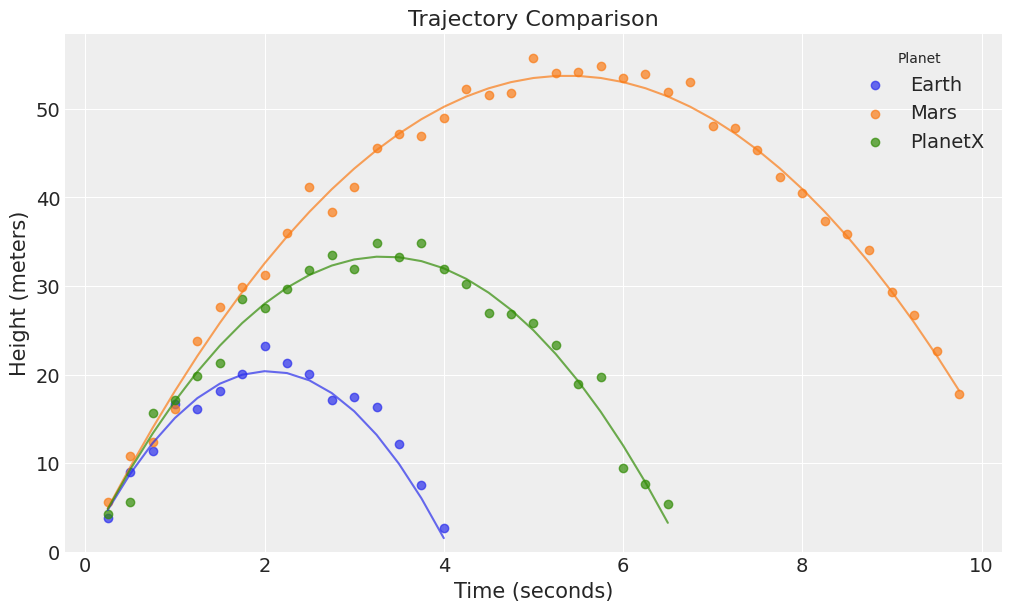

In [28]:
plt.figure(figsize=(10, 6))
for i, planet in enumerate(df['Planet'].cat.categories):
    subset = df[df['Planet'] == planet]
    plt.plot(subset['Time'], subset['Height_true'], alpha=0.7, color=f'C{i}')
    plt.scatter(subset['Time'], subset['Height'], alpha=0.7, label=planet, color=f'C{i}')
plt.legend(title='Planet')
plt.title('Trajectory Comparison')
plt.xlabel('Time (seconds)')
plt.ylabel('Height (meters)')
plt.ylim(bottom=0);

We now aim to model this data. We again use the folowing equation (calling displacement $h$ for height):

$$
h = \frac{1}{2} g_{p} t^2 + v_{0} t
$$

where $g_p$ now has a subscript to indicate the planet that we're throwing from.

In Bambi, we'll do the following:

`Height ~ I(Time**2):Planet + Time + 0`

which corresponds one-to-one with the above formula. The intercept is eliminated since we start from $x=0$. We will use random effects in this case for our planets.

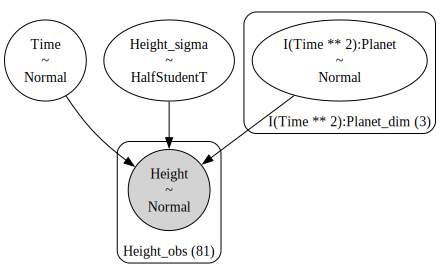

In [29]:
planet_model = bmb.Model(
    'Height ~ I(Time**2):Planet + Time + 0',
    df,
)
planet_model.build()
planet_model.graph()

In [30]:
planet_fit = planet_model.fit(idata_kwargs={"log_likelihood": True}, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Height_sigma, I(Time ** 2):Planet, Time]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


The model has fit. Let's look at how we did recovering the simulated parameters.

In [31]:
az.summary(planet_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I(Time ** 2):Planet[Earth],-4.773,0.063,-4.899,-4.660,0.002,0.001,1720.0,1971.0,1.0
I(Time ** 2):Planet[Mars],-1.857,0.018,-1.889,-1.822,0.001,0.000,1245.0,1566.0,1.0
I(Time ** 2):Planet[PlanetX],-2.988,0.030,-3.040,-2.932,0.001,0.001,1300.0,1825.0,1.0
Time,20.009,0.138,19.757,20.267,0.004,0.003,1231.0,1527.0,1.0
Height_sigma,1.472,0.125,1.256,1.719,0.003,0.002,1631.0,1289.0,1.0


Getting the gravities back to the physical value,

In [32]:
hdi = az.hdi(planet_fit.posterior, hdi_prob=0.95)
print(f"g for Earth: {2*hdi['I(Time ** 2):Planet'].sel({'I(Time ** 2):Planet_dim':'Earth', 'hdi':'lower'}):.2f} to {2*hdi['I(Time ** 2):Planet'].sel({'I(Time ** 2):Planet_dim':'Earth', 'hdi':'higher'}):.2f} meters (True: -9.81 m)")
print(f"g for Mars: {2*hdi['I(Time ** 2):Planet'].sel({'I(Time ** 2):Planet_dim':'Mars', 'hdi':'lower'}):.2f} to {2*hdi['I(Time ** 2):Planet'].sel({'I(Time ** 2):Planet_dim':'Mars', 'hdi':'higher'}):.2f} meters (True: -3.72 m)")
print(f"g for PlanetX: {2*hdi['I(Time ** 2):Planet'].sel({'I(Time ** 2):Planet_dim':'PlanetX', 'hdi':'lower'}):.2f} to {2*hdi['I(Time ** 2):Planet'].sel({'I(Time ** 2):Planet_dim':'PlanetX', 'hdi':'higher'}):.2f} meters (True: -6.0 m)")
print(f"Initial velocity: {hdi['Time'].sel(hdi='lower'):.2f} to {hdi['Time'].sel(hdi='higher'):.2f} meters per second (True: 20 m/s)")


g for Earth: -9.80 to -9.30 meters (True: -9.81 m)
g for Mars: -3.78 to -3.64 meters (True: -3.72 m)
g for PlanetX: -6.09 to -5.86 meters (True: -6.0 m)
Initial velocity: 19.74 to 20.27 meters per second (True: 20 m/s)


We can see that we're pretty close to recovering most the parameters, but the fit isn't great. Plotting the posteriors for $g$ agsint the true values,

Text(0.5, 1.0, 'Posterior $g$ on PlanetX')

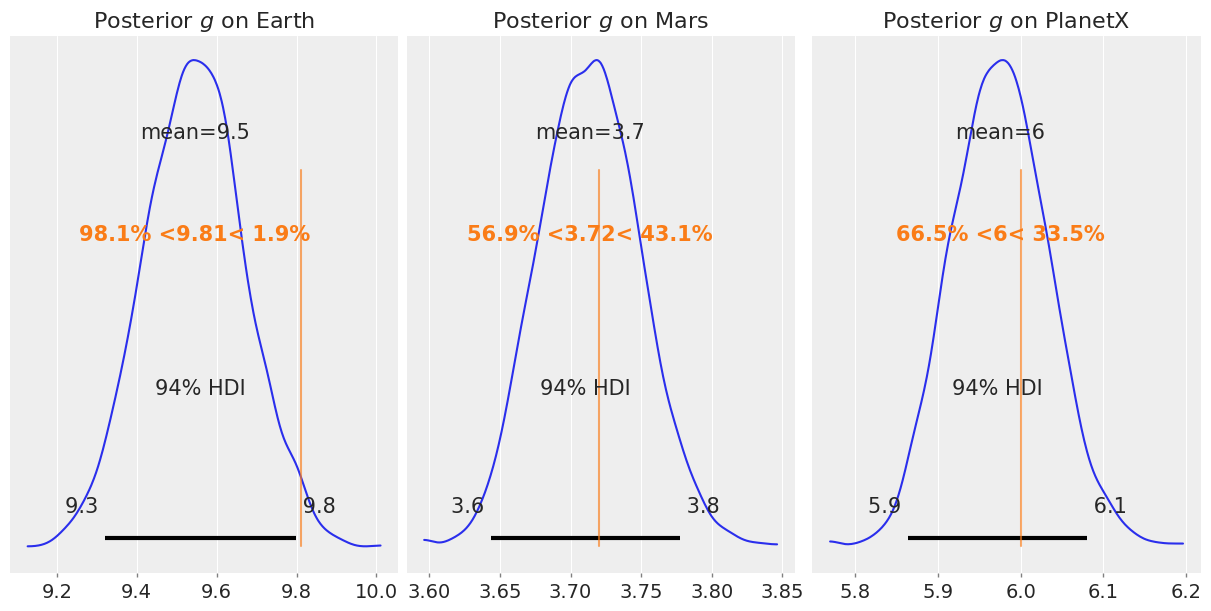

In [33]:
earth_posterior = -2 * planet_fit.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "Earth"})
planetx_posterior = -2 * planet_fit.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "PlanetX"})
mars_posterior = -2 * planet_fit.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "Mars"}) 

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
az.plot_posterior(earth_posterior, ref_val=9.81, ax=axs[0])
axs[0].set_title("Posterior $g$ on Earth")
az.plot_posterior(mars_posterior, ref_val=3.72, ax=axs[1])
axs[1].set_title("Posterior $g$ on Mars")
az.plot_posterior(planetx_posterior, ref_val=6.0, ax=axs[2])
axs[2].set_title("Posterior $g$ on PlanetX")

The fit seems to work, more or less, but certainly could be improved.

### Adding a prior

But, we can do better! We have a [very good idea of the acceleration due to gravity on Earth](https://en.wikipedia.org/wiki/Gravity_of_Earth) and [Mars](https://en.wikipedia.org/wiki/Gravity_of_Mars), so why not use that information? From an experimental standpoint, we can consider these throws from a calibration mindset, allowing us to get some information on the resolution of our detector, and our throwing apparatus. The model will spend considerably less time trying pin down those parameters, and will better explore other parameters with already good values of the $g$ terms locked in.

For Earth, at the extremes, $g$ takes values as low as 9.78 $m$/$s^2$ (at the Equator) up to 9.83 (at the Poles). So we can add a very strong prior,

$$
g_{\text{Earth}} \sim \text{Normal}(-9.81, 0.025)
$$

For Mars, we know the mean value is about 3.72 $m$/$s^2$. There's less information on local variation readily available by a cursory search, _however_ we know that the radius of Mars is about half that of Earth, so $\sigma = \frac{0.025}{2} = 0.0125$ might make sense, but to be conservative we'll round that up to $\sigma = 0.02$.

$$
g_{\text{Mars}} \sim \text{Normal}(-3.72, 0.02)
$$

For PlanetX, we must use a very loose prior. We might say that we know the ball took longer to fall than Earth, but not as long as on Mars, so we can split the difference. Then set a very wide $\sigma$ value.

$$
g_{\text{PlanetX}} \sim \text{Normal}(\frac{-9.81 - 3.72}{2}, 3) = \text{Normal}(-6.77, 3)
$$

Since these correspond to $g/2$, we'll divide all values by 2 when putting them into Bambi. Additionally, we know the balls landed eventually, so $g$ _must be_ negative. We'll truncate the upper limit of the distribution at 0.

Now, for defining this in Bambi, the term of interest is `I(Time ** 2):Planet`. Often, you set one prior that applies to all groups, however, if you want to set each group individually, you can pass a list to the `bmb.Prior` definition. [The broadcasting rules from PyMC apply here](https://github.com/bambinos/bambi/issues/778), so it could equivalently take a numpy array. You'll notice that the priors are passed alphabetically by group name.

In [34]:

priors = {
    "I(Time ** 2):Planet": bmb.Prior(
        'TruncatedNormal',
        mu=[
            -9.81/2,  # Earth
            -3.72/2,  # Mars
            -6.77/2    # PlanetX
        ],
        sigma=[ 
            0.025/2,  # Earth 
            0.02/2,   # Mars
            3/2       # PlanetX
        ],
        upper=[0, 0, 0]
    )} 

planet_model_with_prior = bmb.Model(
    'Height ~ I(Time**2):Planet + Time + 0',
    df,
    priors=priors
)

planet_model_with_prior.build()
idata = planet_model_with_prior.prior_predictive()
az.summary(idata.prior, kind="stats")

Sampling: [Height, Height_sigma, I(Time ** 2):Planet, Time]


,mean,sd,hdi_3%,hdi_97%
Time,0.028,14.999,-27.840,25.887
Height_sigma,15.594,14.454,0.031,38.813
I(Time ** 2):Planet[Earth],-4.905,0.013,-4.928,-4.881
I(Time ** 2):Planet[Mars],-1.860,0.010,-1.878,-1.840
I(Time ** 2):Planet[PlanetX],-3.430,1.358,-5.730,-0.798


Here we've sampled the prior predictive and can see that our priors are correctly specified to the associated planets.

Next we fit the model.

In [35]:
planet_fit_with_prior = planet_model_with_prior.fit(idata_kwargs={"log_likelihood": True}, random_seed=SEED)
az.summary(planet_fit_with_prior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Height_sigma, I(Time ** 2):Planet, Time]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Time,20.101,0.070,19.975,20.240,0.002,0.001,2051.0,2199.0,1.0
Height_sigma,1.501,0.122,1.272,1.728,0.002,0.002,3688.0,2731.0,1.0
I(Time ** 2):Planet[Earth],-4.898,0.012,-4.921,-4.874,0.000,0.000,3531.0,2470.0,1.0
I(Time ** 2):Planet[Mars],-1.867,0.008,-1.883,-1.851,0.000,0.000,2279.0,2408.0,1.0
I(Time ** 2):Planet[PlanetX],-3.005,0.020,-3.042,-2.967,0.000,0.000,2170.0,2541.0,1.0


We see some improvements here! Off the cuff, these look better, you'll notice the $v_0$ coefficient on `Time` covers the true value of 20 m/s.

Now taking a look at the effects before and after adding the prior on the gravities,

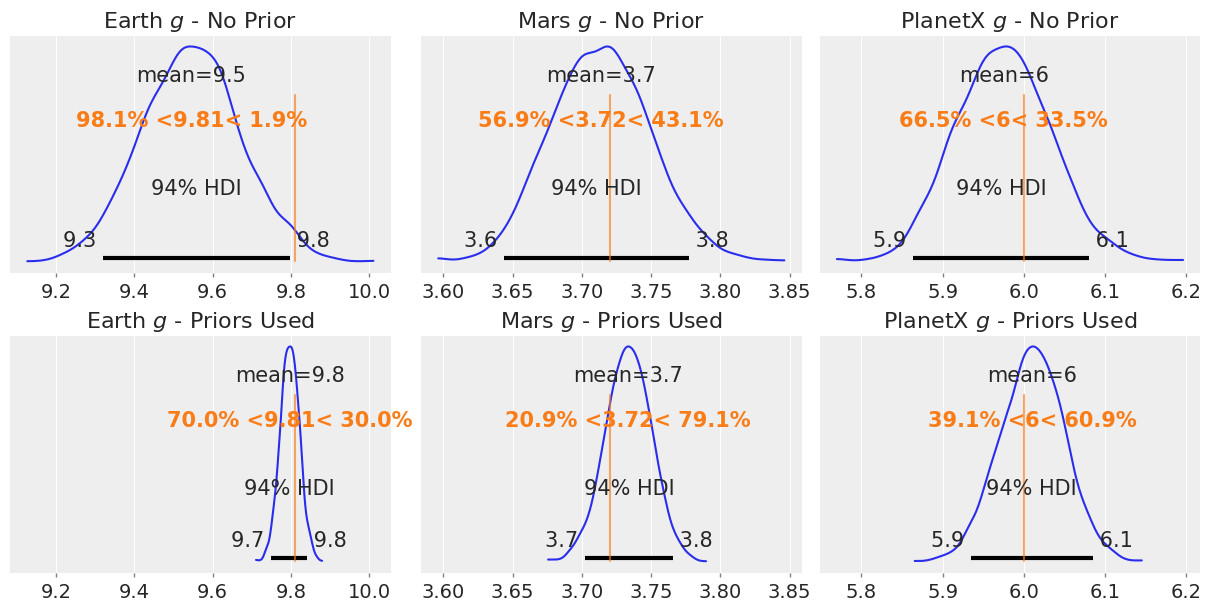

In [36]:
earth_posterior_2 = -2 *  planet_fit_with_prior.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "Earth"})
mars_posterior_2 = -2 * planet_fit_with_prior.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "Mars"})
planetx_posterior_2 = -2 * planet_fit_with_prior.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "PlanetX"})

fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex='col')
az.plot_posterior(earth_posterior, ref_val=9.81, ax=axs[0,0])
axs[0,0].set_title("Earth $g$ - No Prior")
az.plot_posterior(mars_posterior, ref_val=3.72, ax=axs[0,1])
axs[0,1].set_title("Mars $g$ - No Prior")
az.plot_posterior(planetx_posterior, ref_val=6.0, ax=axs[0,2])
axs[0,2].set_title("PlanetX $g$ - No Prior")


az.plot_posterior(earth_posterior_2, ref_val=9.81, ax=axs[1,0])
axs[1,0].set_title("Earth $g$ - Priors Used")
az.plot_posterior(mars_posterior_2, ref_val=3.72, ax=axs[1,1])
axs[1,1].set_title("Mars $g$ - Priors Used")
az.plot_posterior(planetx_posterior_2, ref_val=6.0, ax=axs[1,2])
axs[1,2].set_title("PlanetX $g$ - Priors Used");


Adding the prior gives smaller uncertainties for Earth and Mars by design, however, we can see the estimate for PlanetX has also considerably improved by injecting our knowledge into the model.

### Adding some complications

Careful! It's dangerous to go alone. After your stellar (excuse the pun) initial research, you've been funded to bring along a full research team to PlanetX. Unlike before, $v_0$ is not a fixed value. Instead, each astronaut has their own mean value, and throws are drawn from a distribution around them.

Since you are a team, you can stay on the planet long enough for each of you to have 5 throws on each planet. 

In [37]:
def simulate_throw(v0, g, noise_std, time_step=0.25, max_time=10):
    """
    Simulate the throw of a ball with varying astronaut strengths and ball noise.
    """
    times = np.arange(0, max_time, time_step)
    heights = v0 * times - 0.5 * g * times**2
    heights_with_noise = heights + np.random.normal(0, noise_std, len(times))
    valid_indices = heights_with_noise >= 0
    return times[valid_indices], heights_with_noise[valid_indices], heights[valid_indices]

# Define astronauts' strengths
np.random.seed(1234)
population_mean = 17  # m/s
population_sd = 2
individual_sd = 1
astronaut_names = ["You", "Kirk", "Leia", "Spock", "Scotty", "Luke"]
astronauts = {n: np.random.normal(population_mean, population_sd) for n in astronaut_names}

# Define planets' gravitational acceleration
g_planets = {'Earth': 9.81, 'Mars': 3.72, 'PlanetX': 6.0}

# Define ball noise
noise_std = 2.5

# Generate data
records = []
throws_per_astronaut = 5  # Number of throws per astronaut
throw_id = 0  # Unique identifier for each throw

for astronaut_name, astronaut_strength in astronauts.items():
    for i in range(throws_per_astronaut):  # Iterate over the number of throws
        v0 = np.random.normal(astronaut_strength, individual_sd)  # Sample initial velocity for each throw
        for planet, g in g_planets.items():
            times, heights, heights_true = simulate_throw(v0, g, noise_std)
            for time, height, height_true in zip(times, heights, heights_true):
                records.append([throw_id, astronaut_name, planet, time, height, height_true])
                    # Increment throw_id for the next record
            throw_id += 1 

# Convert to DataFrame
df = pd.DataFrame(records, columns=['Throw_ID', 'Astronaut', 'Planet', 'Time', 'Height', "Height_true"])
df["Planet"] = df["Planet"].astype('category')

Due to the differing strengths, the trajectories look different per astronaut.

/Users/tburch/Documents/git_repos/bambi/bambi_dev_env/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


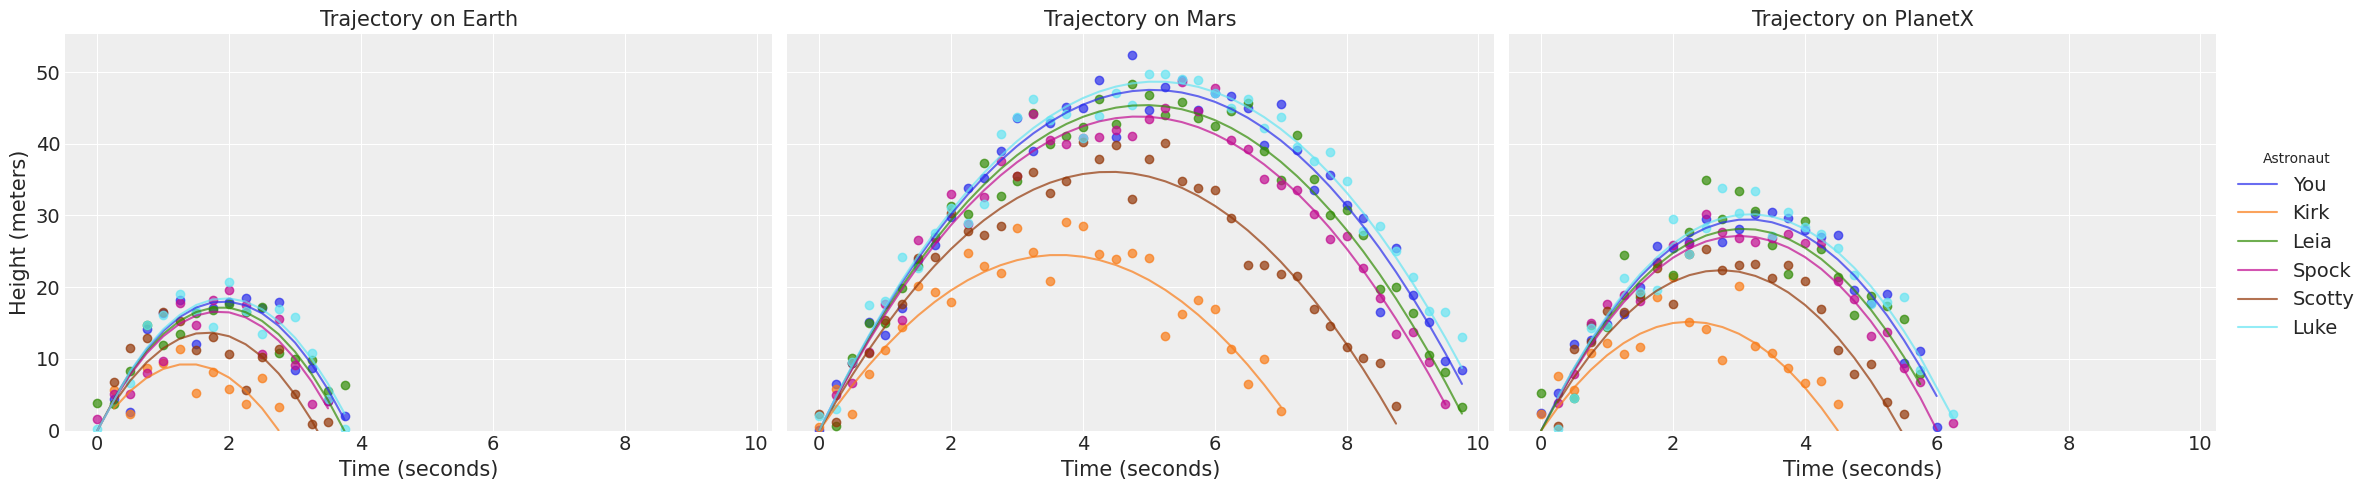

In [38]:
throws_to_show = df.groupby(['Astronaut', 'Planet'], observed=False).head(1).Throw_ID.values
df_show = df[df.Throw_ID.isin(throws_to_show)]


g = sns.FacetGrid(df_show, col="Planet", hue="Astronaut", height=5, aspect=1.5)
g.map(plt.scatter, "Time", "Height", alpha=0.7)
g.map(plt.plot, "Time", "Height_true", alpha=0.7)
g.add_legend()

g.set_titles("Trajectory on {col_name}")
g.set_axis_labels("Time (seconds)", "Height (meters)")
g.set(ylim=(0));

Our model is as follows:

$$
\text{Height}_{ij} \sim \text{Normal}(\mu_{ij}, \sigma)
$$

$$
\mu_{ij} = \beta_{\text{planet,}i} \cdot \text{Time}_{ij}^2 + \beta_{\text{astronaut,}j} \cdot \text{Time}_{ij}
$$

Letting the astronaut effect be hierarchical, their strengths are drawn from a normal distribution with population parameters $\mu_{\text{pop}}$ and $\sigma_{\text{pop}}$

$$
\beta_{\text{astronaut,}j} \sim \text{Normal}(\mu_{\text{pop}}, \sigma_{\text{pop}})
$$



We will again start without specifying priors and later add them to see the effect.

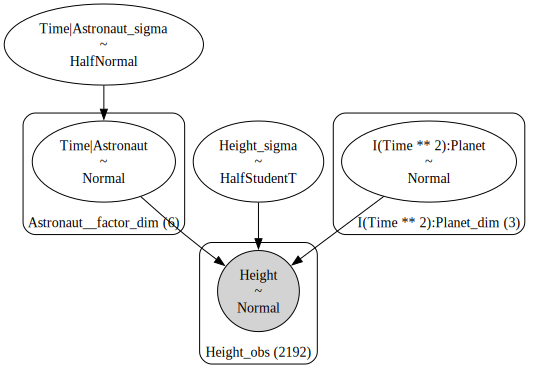

In [39]:
measurement_mod_hier = bmb.Model(
    formula='Height ~  I(Time**2):Planet +  (0 + Time|Astronaut) + 0',
    data=df,
    noncentered=False
)
measurement_mod_hier.build()
measurement_mod_hier.graph()

We will fit this model and look how it does, quickly creating a new column for the mean value for $g$ in the summary table.

In [40]:
measurement_fit_hier = measurement_mod_hier.fit(
    idata_kwargs={"log_likelihood": True}, random_seed=SEED
)

hier_summary = az.summary(measurement_fit_hier)
g_mean = -2 * hier_summary["mean"]
hier_summary["g_mean"] = np.append(g_mean[0:3], np.repeat(np.nan, len(g_mean)-3))
hier_summary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Height_sigma, I(Time ** 2):Planet, Time|Astronaut_sigma, Time|Astronaut]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,g_mean
I(Time ** 2):Planet[Earth],-4.654,0.046,-4.739,-4.568,0.001,0.001,1487.0,2663.0,1.0,9.308
I(Time ** 2):Planet[Mars],-1.784,0.012,-1.806,-1.761,0.000,0.000,812.0,1082.0,1.0,3.568
I(Time ** 2):Planet[PlanetX],-2.847,0.021,-2.886,-2.808,0.001,0.000,908.0,1453.0,1.0,5.694
Time|Astronaut[Kirk],14.433,0.096,14.256,14.614,0.003,0.002,1078.0,1911.0,1.0,NaN
Time|Astronaut[Leia],18.939,0.098,18.748,19.120,0.003,0.002,916.0,1465.0,1.0,NaN
Time|Astronaut[Luke],17.898,0.098,17.713,18.079,0.003,0.002,909.0,1564.0,1.0,NaN
Time|Astronaut[Scotty],15.472,0.097,15.289,15.651,0.003,0.002,1125.0,1733.0,1.0,NaN
Time|Astronaut[Spock],16.470,0.095,16.289,16.647,0.003,0.002,992.0,1790.0,1.0,NaN
Time|Astronaut[You],17.319,0.096,17.143,17.502,0.003,0.002,939.0,1559.0,1.0,NaN
Height_sigma,4.294,0.066,4.174,4.424,0.001,0.001,3304.0,2909.0,1.0,NaN


It appears like the acceleration due to gravity is substantially underpredicted. Visualizing,

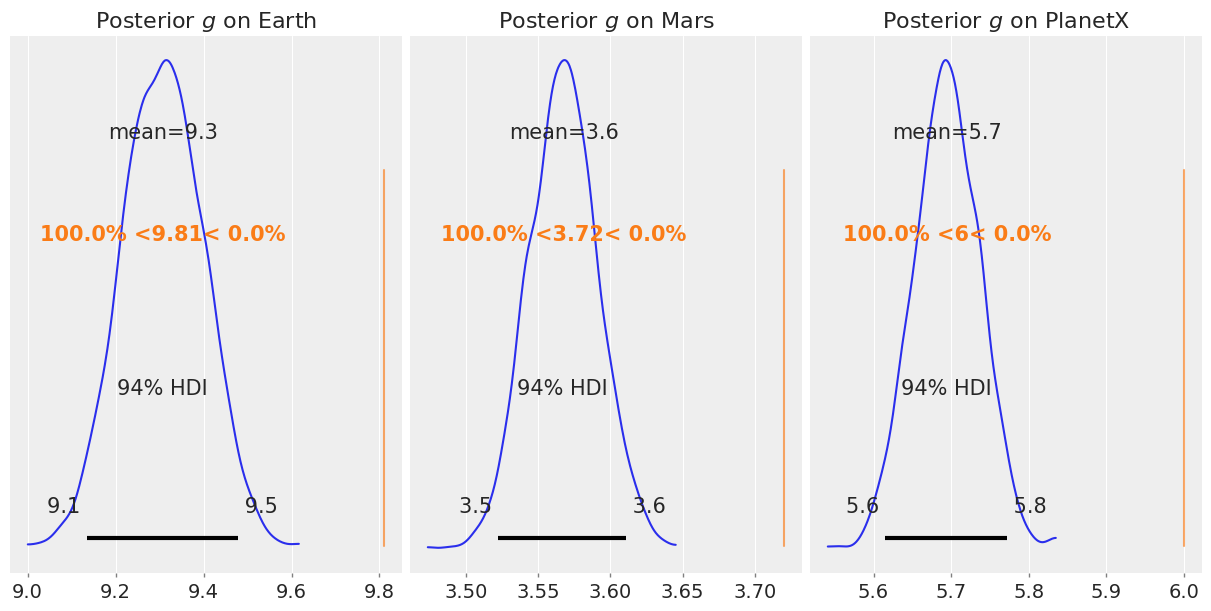

In [41]:
earth_posterior = -2 * measurement_fit_hier.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "Earth"})
planetx_posterior = -2 * measurement_fit_hier.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "PlanetX"})
mars_posterior = -2 * measurement_fit_hier.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "Mars"}) 

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
az.plot_posterior(earth_posterior, ref_val=9.81, ax=axs[0])
axs[0].set_title("Posterior $g$ on Earth")
az.plot_posterior(mars_posterior, ref_val=3.72, ax=axs[1])
axs[1].set_title("Posterior $g$ on Mars")
az.plot_posterior(planetx_posterior, ref_val=6.0, ax=axs[2])
axs[2].set_title("Posterior $g$ on PlanetX");

Next, we consider adding priors. For the planet priors we use the same as before

$$
\beta_{\text{planet,Earth}} \sim \text{Normal}(\frac{-9.81}{2}, \frac{0.025}{2})
$$

$$
\beta_{\text{planet,Mars}} \sim \text{Normal}(\frac{-3.72}{2}, \frac{0.02}{2})
$$

$$
\beta_{\text{planet,PlanetX}} \sim \text{Normal}(\frac{-6.77}{2}, \frac{3}{2})
$$

And for astonauts,

$$
\beta_{\text{astonaut,}i} \sim \text{Normal}(\mu_{ij}, \sigma)
$$

$$
\mu_i \sim \text{Normal(17, 4)}
$$



In [42]:
priors = {
    "I(Time ** 2):Planet": bmb.Prior(
        'TruncatedNormal',
        mu=[
            -9.81/2,  # Earth
            -3.72/2,  # Mars
            -6.0/2    # PlanetX
        ],
        sigma=[ 
            0.025/2,  # Earth 
            0.02/2,   # Mars
            4         # PlanetX
        ],
        upper=[0, 0, 0]
    ),
    # TODO - this doesn't seem to work, guidance would be helpful
    #"Time|Astronaut": bmb.Prior(
    #    'Normal',
    #    mu=17,
    #    sigma=4
    #)
}
measurement_mod_hier_prior = bmb.Model(
    formula='Height ~  I(Time**2):Planet +  (0 + Time|Astronaut) + 0',
    data=df,
    priors =priors,
    noncentered=False
)
measurement_fit_hier_prior = measurement_mod_hier_prior.fit(idata_kwargs={"log_likelihood": True}, target_accept=0.95, random_seed=SEED)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Height_sigma, I(Time ** 2):Planet, Time|Astronaut_sigma, Time|Astronaut]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [43]:
az.summary(measurement_fit_hier_prior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Time|Astronaut[Kirk],14.775,0.077,14.642,14.928,0.002,0.001,2379.0,2892.0,1.0
Time|Astronaut[Leia],19.368,0.067,19.244,19.497,0.001,0.001,2045.0,2356.0,1.0
Time|Astronaut[Luke],18.312,0.069,18.185,18.445,0.002,0.001,2069.0,2764.0,1.0
Time|Astronaut[Scotty],15.836,0.075,15.705,15.986,0.002,0.001,2270.0,2821.0,1.0
Time|Astronaut[Spock],16.857,0.070,16.725,16.987,0.001,0.001,2272.0,2725.0,1.0
Time|Astronaut[You],17.726,0.069,17.603,17.854,0.001,0.001,2244.0,2643.0,1.0
Height_sigma,4.321,0.063,4.198,4.435,0.001,0.001,4240.0,2828.0,1.0
I(Time ** 2):Planet[Earth],-4.892,0.012,-4.913,-4.869,0.000,0.000,3698.0,2995.0,1.0
I(Time ** 2):Planet[Mars],-1.840,0.007,-1.852,-1.827,0.000,0.000,1585.0,2169.0,1.0
I(Time ** 2):Planet[PlanetX],-2.931,0.015,-2.959,-2.903,0.000,0.000,1818.0,2715.0,1.0


Comparing the two,

In [44]:
az.compare({"No Priors": measurement_fit_hier, "Added prior": measurement_fit_hier_prior})

/Users/tburch/Documents/git_repos/bambi/bambi_dev_env/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/tburch/Documents/git_repos/bambi/bambi_dev_env/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
No Priors,0,-6311.416294,15.746385,0.000000,0.899518,37.660218,0.000000,False,log
Added prior,1,-6325.090159,14.341014,13.673864,0.100482,37.360115,5.878902,False,log


NOTE - Probably model misspecification, understand why it's worse

In [45]:
az.summary(measurement_fit_hier_prior).iloc[0:15,:]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Time|Astronaut[Kirk],14.775,0.077,14.642,14.928,0.002,0.001,2379.0,2892.0,1.0
Time|Astronaut[Leia],19.368,0.067,19.244,19.497,0.001,0.001,2045.0,2356.0,1.0
Time|Astronaut[Luke],18.312,0.069,18.185,18.445,0.002,0.001,2069.0,2764.0,1.0
Time|Astronaut[Scotty],15.836,0.075,15.705,15.986,0.002,0.001,2270.0,2821.0,1.0
Time|Astronaut[Spock],16.857,0.070,16.725,16.987,0.001,0.001,2272.0,2725.0,1.0
Time|Astronaut[You],17.726,0.069,17.603,17.854,0.001,0.001,2244.0,2643.0,1.0
Height_sigma,4.321,0.063,4.198,4.435,0.001,0.001,4240.0,2828.0,1.0
I(Time ** 2):Planet[Earth],-4.892,0.012,-4.913,-4.869,0.000,0.000,3698.0,2995.0,1.0
I(Time ** 2):Planet[Mars],-1.840,0.007,-1.852,-1.827,0.000,0.000,1585.0,2169.0,1.0
I(Time ** 2):Planet[PlanetX],-2.931,0.015,-2.959,-2.903,0.000,0.000,1818.0,2715.0,1.0


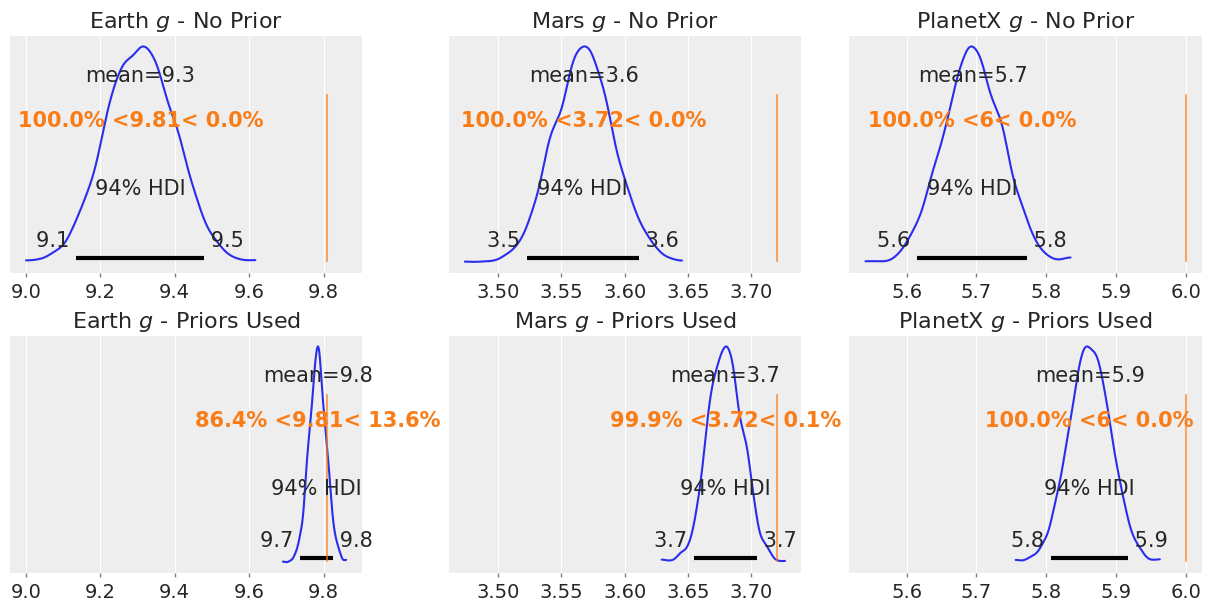

In [46]:
earth_posterior = -2 *  measurement_fit_hier.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "Earth"})
mars_posterior = -2 * measurement_fit_hier.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "Mars"})
planetx_posterior = -2 * measurement_fit_hier.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "PlanetX"})

earth_posterior_2 = -2 *  measurement_fit_hier_prior.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "Earth"})
mars_posterior_2 = -2 * measurement_fit_hier_prior.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "Mars"})
planetx_posterior_2 = -2 * measurement_fit_hier_prior.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "PlanetX"})

fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex='col')
az.plot_posterior(earth_posterior, ref_val=9.81, ax=axs[0,0])
axs[0,0].set_title("Earth $g$ - No Prior")
az.plot_posterior(mars_posterior, ref_val=3.72, ax=axs[0,1])
axs[0,1].set_title("Mars $g$ - No Prior")
az.plot_posterior(planetx_posterior, ref_val=6.0, ax=axs[0,2])
axs[0,2].set_title("PlanetX $g$ - No Prior")


az.plot_posterior(earth_posterior_2, ref_val=9.81, ax=axs[1,0])
axs[1,0].set_title("Earth $g$ - Priors Used")
az.plot_posterior(mars_posterior_2, ref_val=3.72, ax=axs[1,1])
axs[1,1].set_title("Mars $g$ - Priors Used")
az.plot_posterior(planetx_posterior_2, ref_val=6.0, ax=axs[1,2])
axs[1,2].set_title("PlanetX $g$ - Priors Used");


Again, adding the prior produces noticibly tighter uncertainty bands on both the calculated value of gravitational acceleration on Earth, but also on PlanetX.

A similar effect happens for the initial velocity produced by the astronaut's throws.

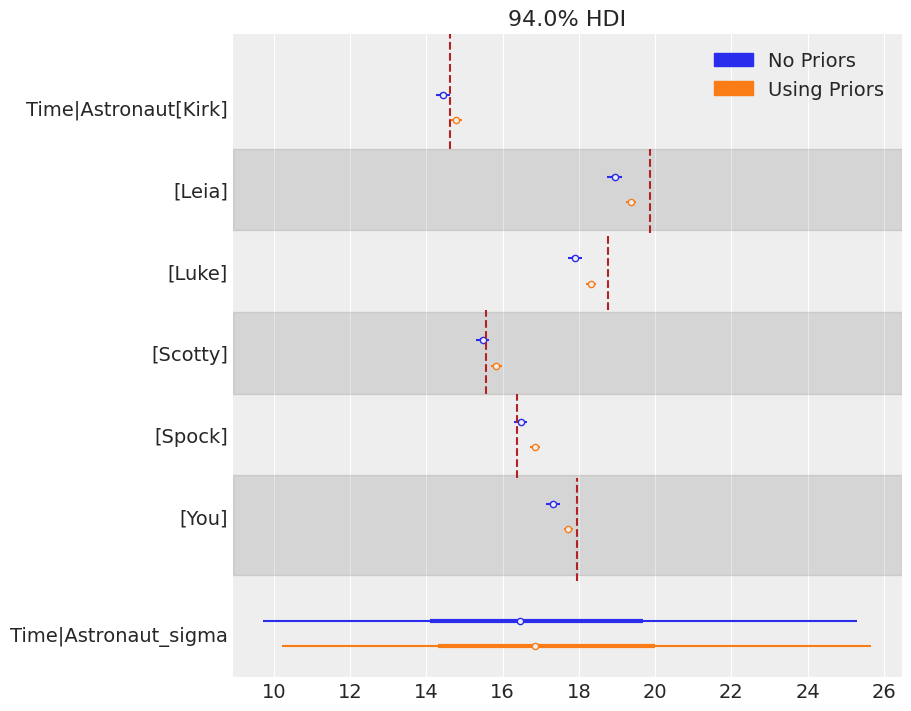

In [47]:
axes = az.plot_forest([measurement_fit_hier, measurement_fit_hier_prior],
                           model_names=["No prior", "Added Prior"],
                           kind='forestplot',
                           var_names="Time|",
                           filter_vars="like",
                           combined=True,
                           figsize=(9, 7))

plot_breaks = [1, .82, .69, .57, .44, .31, .15]
for i, name in enumerate(sorted(astronauts)):
    plt.axvline(
        x=astronauts[name], linestyle='--', color="firebrick",
        ymin=plot_breaks[i+1], ymax=plot_breaks[i])

plt.legend(handles=[mpl.patches.Patch(color='C0', label='No Priors'),
                    mpl.patches.Patch(color='C1', label='Using Priors')],
           loc='upper right');

We can see that largely, the fitted parameters are closer to the true values when the priors are used.